# 图像特征练习
*补充并完成本练习。*

我们已经看到，通过在输入图像的像素上训练线性分类器，从而在图像分类任务上达到一个合理的性能。在本练习中，我们将展示我们可以通过对线性分类器（不是在原始像素上，而是在根据原始像素计算出的特征上）进行训练来改善分类性能。

你将在此notebook中完成本练习的所有工作。

In [1]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 数据加载
与之前的练习类似，我们将从磁盘加载CIFAR-10数据。

In [2]:
from daseCV.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## 特征提取
对于每一张图片我们将会计算它的方向梯度直方图（英語：Histogram of oriented gradient，简称HOG）以及在HSV颜色空间使用色相通道的颜色直方图。

简单来讲，HOG能提取图片的纹理信息而忽略颜色信息，颜色直方图则提取出颜色信息而忽略纹理信息。
因此，我们希望将两者结合使用而不是单独使用任一个。去实现这个设想是一个十分有趣的事情。

`hog_feature` 和 `color_histogram_hsv`两个函数都可以对单个图像进行运算并返回改图像的一个特征向量。
extract_features函数输入一个图像集合和一个特征函数列表然后对每张图片运行每个特征函数，
然后将结果存储在一个矩阵中，矩阵的每一列是单个图像的所有特征向量的串联。

In [3]:
from daseCV.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## 使用特征训练SVM
使用之前作业完成的多分类SVM代码来训练上面提取的特征。这应该比原始数据直接在SVM上训练会去的更好的效果。

In [7]:
# 使用验证集调整学习率和正则化强度

from daseCV.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# 你需要做的: 
# 使用验证集设置学习率和正则化强度。
# 这应该与你对SVM所做的验证相同；
# 将训练最好的的分类器保存在best_svm中。
# 你可能还想在颜色直方图中使用不同数量的bins。
# 如果你细心一点应该能够在验证集上获得0.44以上的准确性。    
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [1e-4, 1e-3, 1e-2]
regularization_strengths = [1e-2, 1e-1, 1]

for lr in learning_rates:
        for rs in regularization_strengths:
            svm = LinearSVM()
            svm.train(X_train_feats, y_train, lr, rs, num_iters=1500)
            
            y_train_pred = svm.predict(X_train_feats)
            train_acc = np.mean(y_train == y_train_pred)
            y_val_pred = svm.predict(X_val_feats)
            val_acc = np.mean(y_val == y_val_pred)
            results[(lr, rs)] = (train_acc, val_acc)
        
            if val_acc > best_val:
                best_val = val_acc
                best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-04 reg 1.000000e-02 train accuracy: 0.450918 val accuracy: 0.450000
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 0.451469 val accuracy: 0.440000
lr 1.000000e-04 reg 1.000000e+00 train accuracy: 0.450449 val accuracy: 0.442000
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 0.501694 val accuracy: 0.487000
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 0.500429 val accuracy: 0.486000
lr 1.000000e-03 reg 1.000000e+00 train accuracy: 0.491265 val accuracy: 0.480000
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 0.509571 val accuracy: 0.490000
lr 1.000000e-02 reg 1.000000e-01 train accuracy: 0.507224 val accuracy: 0.495000
lr 1.000000e-02 reg 1.000000e+00 train accuracy: 0.486041 val accuracy: 0.470000
best validation accuracy achieved during cross-validation: 0.495000


In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.491


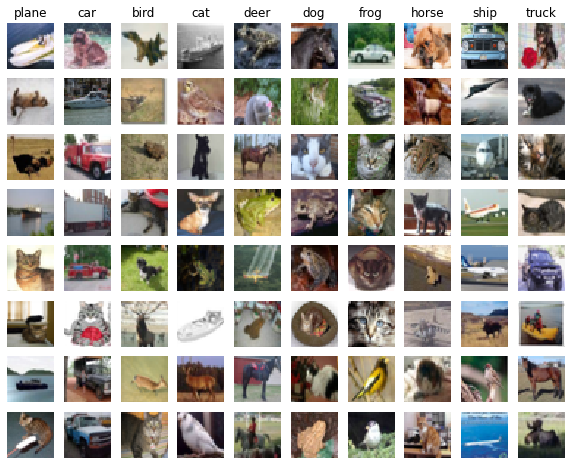

In [9]:
# 直观了解算法工作原理的一种重要方法是可视化它所犯的错误。
# 在此可视化中，我们显示了当前系统未正确分类的图像示例。
# 第一列显示的图像是我们的系统标记为“ plane”，但其真实标记不是“ plane”。

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

**问题 1:**

描述你看到的错误分类结果。你认为他们有道理吗？

$\color{blue}{\textit 答:}$ *有些错误分类结果是有道理的。比如，第一列中的船和猫的图片背景都是蓝色（或青色），与飞机通常所在的天空的颜色相似，可能会导致分类错误。又如汽车和卡车具有许多相似的特征，同样可能会导致分类错误。*

## 图像特征神经网络
在之前的练习中，我们看到在原始像素上训练两层神经网络比线性分类器具有更好的分类精度。在这里，我们已经看到使用图像特征的线性分类器优于使用原始像素的线性分类器。
为了完整起见，我们还应该尝试在图像特征上训练神经网络。这种方法应优于以前所有的方法：你应该能够轻松地在测试集上达到55％以上的分类精度；我们最好的模型可达到约60％的精度。

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [13]:
from daseCV.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
best_acc = 0.0

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
results = {}

################################################################################
# TODO: 使用图像特征训练两层神经网络。
# 您可能希望像上一节中那样对各种参数进行交叉验证。
# 将最佳的模型存储在best_net变量中。                                             
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = np.logspace(-2, 0, 3)
regularization_strengths = np.logspace(-3, -1, 3)

for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            
        # Train the model
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=1500, batch_size=200, 
                          learning_rate=lr, learning_rate_decay=0.95, reg=rs, verbose=False)
        
        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        results[(lr, rs)] = val_acc
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = net
            
# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr 1.000000e-02 reg 1.000000e-03 val accuracy: 0.151000
lr 1.000000e-02 reg 1.000000e-02 val accuracy: 0.172000
lr 1.000000e-02 reg 1.000000e-01 val accuracy: 0.144000
lr 1.000000e-01 reg 1.000000e-03 val accuracy: 0.519000
lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.517000
lr 1.000000e-01 reg 1.000000e-01 val accuracy: 0.431000
lr 1.000000e+00 reg 1.000000e-03 val accuracy: 0.572000
lr 1.000000e+00 reg 1.000000e-02 val accuracy: 0.535000
lr 1.000000e+00 reg 1.000000e-01 val accuracy: 0.363000
best validation accuracy achieved during cross-validation: 0.572000


In [14]:
# 在测试集上运行得到的最好的神经网络分类器，应该能够获得55％以上的准确性。

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.561
